Train and fine-tune a Decision Tree for the moons dataset. The rule is to create 10000 samples for this work with a noise of 0.4

In [1]:
from sklearn import datasets

X, y = datasets.make_moons(n_samples=10000, noise=0.4, random_state=42)

In [2]:
from sklearn.model_selection import train_test_split
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Plot dataset

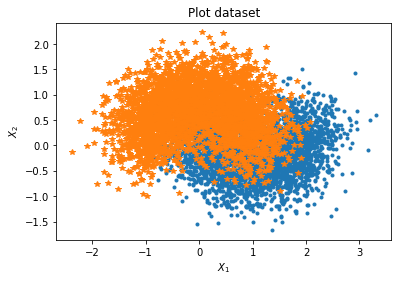

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
def plot_dataset(X, y):
    plt.plot(X[:,0][y==1], X[:,1][y==1], ".")
    plt.plot(X[:,0][y==0], X[:,1][y==0], "*")
    plt.xlabel("$X_1$")
    plt.ylabel("$X_2$")
    plt.title("Plot dataset")
    
plot_dataset(X_train, y_train)

Trees classifier with GridSearchCV

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

y_train_pred = cross_val_predict(estimator=tree_clf, X=X_train, y=y_train, cv=5)

confusion_matrix(y_train, y_train_pred)

array([[2664,  656],
       [ 687, 2693]], dtype=int64)

In [5]:
# See the graph of the first tree_clf
from sklearn.tree import export_graphviz

export_graphviz(
    tree_clf, 
    out_file="C:\\Users\\User\\PycharmProjects\\ScikitLearnBook\\Decision_trees\\tree_moons.dot",
    feature_names=["$X_1$", "$X_2$"],
    rounded=True,
    filled= True
)

In [6]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

def display_scores(y_true, y_pred):
    print("f1 score : ", f1_score(y_true, y_pred))
    print("Recall : ", recall_score(y_true, y_pred))
    print("Precision : ", precision_score(y_true, y_pred))

display_scores(y_train, y_train_pred)

f1 score :  0.8004161093773221
Recall :  0.7967455621301776
Precision :  0.8041206330247835


f1 score = 80% in CV 

We can improve this score tweaking the parameters of the tree classifier

In [7]:
tree_clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 42,
 'splitter': 'best'}

In [8]:
from sklearn.model_selection import GridSearchCV
params = {
    'max_leaf_nodes' : [1, 3, 10, 30, 100, 300, 1000, 3000]
}

gsv = GridSearchCV(estimator=tree_clf, param_grid=params, cv=5)
grid_results = gsv.fit(X_train, y_train)

best_params = grid_results.best_params_

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "c:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\tree\_classes.py", line 284, in fit
    raise ValueError(("max_leaf_nodes {0} must be either None "
ValueError: max_leaf_nodes 1 must be either None or larger than 1

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\user\appdata\local\programs\python\python38\lib\si

In [9]:
best_tree_clf = DecisionTreeClassifier(max_leaf_nodes = best_params['max_leaf_nodes'])


In [10]:
y_best_clf_pred = cross_val_predict(estimator=best_tree_clf, X=X_train, y=y_train, cv=5)
confusion_matrix(y_train, y_best_clf_pred)


array([[2881,  439],
       [ 507, 2873]], dtype=int64)

In [11]:
display_scores(y_train, y_best_clf_pred)

f1 score :  0.8586371787208608
Recall :  0.85
Precision :  0.8674516908212561


Made an improvement of 5% of classification

f1_score is now 85% with a cross-validation set

Plot the graph of the decisionTreeRegressor

In [12]:
export_graphviz(
    tree_clf, 
    out_file="C:\\Users\\User\\PycharmProjects\\ScikitLearnBook\\Decision_trees\\tree_moons_optimised.dot",
    feature_names=["$X_1$", "$X_2$"],
    rounded=True,
    filled= True
)

In [13]:
best_tree_clf.fit(X_train, y_train)
y_test_pred = best_tree_clf.predict(X=X_test)
display_scores(y_test, y_test_pred)

f1 score :  0.8605798889574336
Recall :  0.8611111111111112
Precision :  0.8600493218249076


We have a f1 score of 8-% and in the deposit pretends to have around 87% !
Prediction with this model is good.

<ins>Deposit :</ins> <b>grow a forest</b>

Generate 1000 subsets of training set containing 100 instances selected randomly

In [14]:
from sklearn.model_selection import ShuffleSplit

rs = ShuffleSplit(n_splits=1000, test_size=len(X) - 100, random_state=42)

mini_train_set = []

for train_index, test_index in rs.split(X):
    X_mini_train = X[train_index]
    y_mini_train = y[train_index]
    mini_train_set.append((X_mini_train, y_mini_train))

In [15]:
import numpy as np
np.shape(y_mini_train)


(100,)

In [16]:
from sklearn.base import clone
from sklearn.metrics import accuracy_score

forest = [clone(gsv.best_estimator_) for _ in range(1000)]

accuracy_scores = []

for tree, (X_mini_train, y_mini_train) in zip(forest, mini_train_set):
    tree.fit(X_mini_train, y_mini_train)
    y_pred = tree.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))


np.mean(accuracy_scores)


0.7963260606060605

In [17]:
Y_pred = np.zeros([1000, len(X_test)])

for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)

In [19]:
from scipy.stats import mode
y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)



In [20]:
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))



0.8696969696969697